In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import train_test_split
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import torch.autograd as autograd
import pandas
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
%matplotlib inline

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
df = pd.read_csv('all_data_Moscow_mean_T.csv')
df.head()

,Unnamed: 0,date,T
0,0,20151201,272.237556
1,1,20151202,270.353706
2,2,20151203,270.480820
3,3,20151204,272.624268
4,4,20151205,274.647697


Populating the interactive namespace from numpy and matplotlib


C:\Python\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


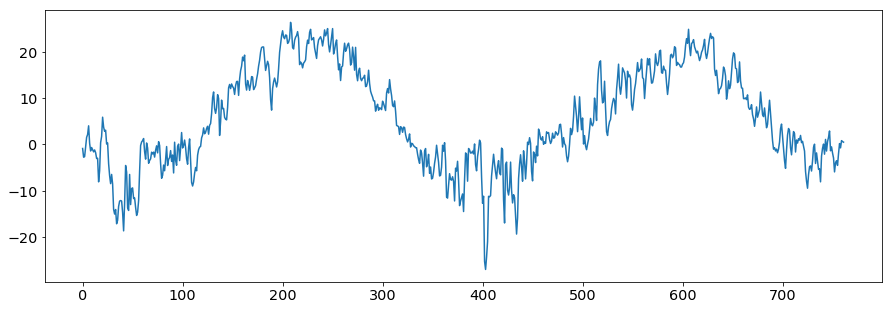

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 5)

T = df['T'] - 273.15
plt.plot(T)

In [4]:
T.size

762

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.001)

# LSTM class code from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
    
        self.apply(init_weights)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))

        return y_pred.view(-1)

In [6]:
num_epoches = 500
look_back = 180
hidden_size = 30
num_layers = 2

In [7]:
T_train = T[:600]
T_test = T[600:]
train = T_train.values.astype('Float32')

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i: (i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def create_test_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[(i - look_back): i])
        dataY.append(dataset[i])
    return np.array(dataX), np.array(dataY)

In [9]:
trainX, trainY = create_dataset(train, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [10]:
model = LSTM(look_back, hidden_size, num_layers = num_layers, batch_size=1)
trainX_ten = torch.Tensor(trainX)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
model

LSTM(
  (lstm): LSTM(180, 30, num_layers=2)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

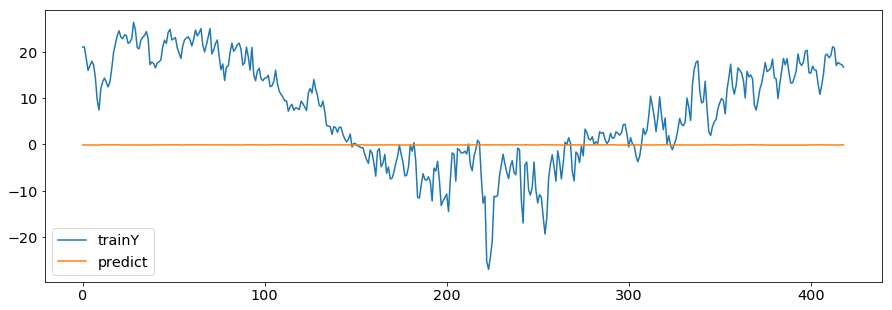

In [11]:
predict = []
for tr in trainX_ten:
    predict.extend([model(tr)])
plt.plot(trainY, label='trainY')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

In [12]:
def draw_plot(loss_values, loss):
    clear_output(True)
    print('Loss is ' + str(loss.item()))
    plt.figure(figsize=(12, 5))
    plt.plot(loss_values, label='Train')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [13]:
# loss_values = []
# for epoch in range(num_epoches):
#     model.zero_grad()
#     model.hidden = model.init_hidden()
#     losses = []
#     for trX, trY in zip(trainX_ten, trainY):
#         model.zero_grad()
#         prediction = model.forward(trX)
#         loss = loss_function(prediction, torch.tensor(trY))
#         losses.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     loss_cur = np.mean(losses)
#     loss_values.append(loss_cur)        
#     draw_plot(loss_values, loss_cur)

model.load_state_dict(torch.load('model_good4'))

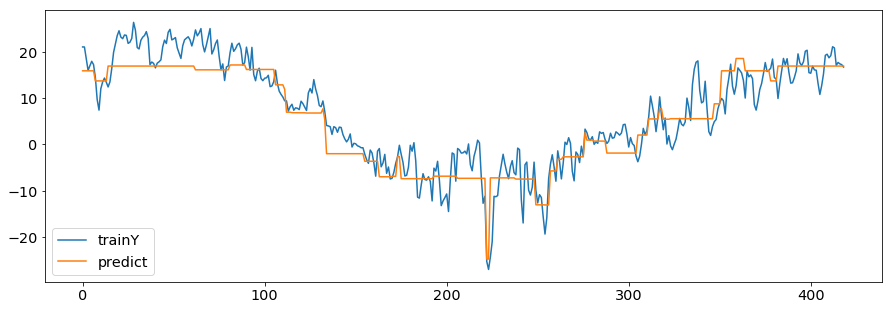

In [14]:
predict = []
for tr in trainX_ten:
    predict.extend([model(tr)])
plt.plot(trainY, label='trainY')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

In [16]:
testX, testY = create_test_dataset(T.values.astype('Float32'), look_back)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [17]:
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
testX_ten = torch.Tensor(testX)

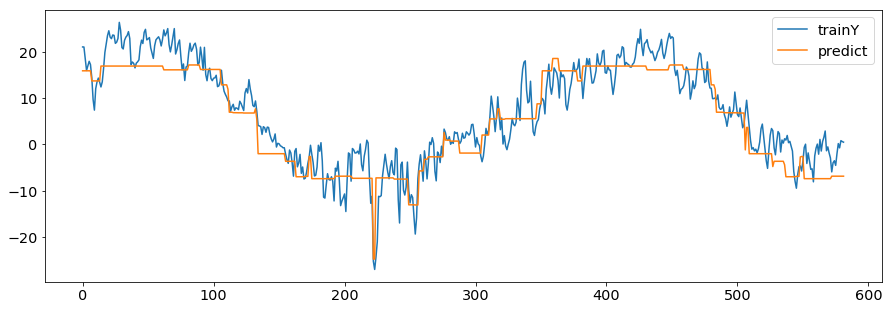

In [19]:
predict = []
for tr in testX_ten:
    predict.extend([model(tr)])
plt.plot(testY, label='trainY')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

In [20]:
MSE(predict, testY)

17.599209787085563

### Long-term predict

In [22]:
pred = []
for tr in testX_ten[:600 - look_back]:
    pred.extend([model(tr)])
X = testX_ten[600 - look_back]
predict = model(X)
pred.extend([predict])
X = X[0]
for _ in range(len(pred), testY.size):
    X = np.append(X[1:], predict.detach().numpy())
    predict = model(torch.tensor([X]))
    pred.append(predict.detach().item())

C:\Python\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


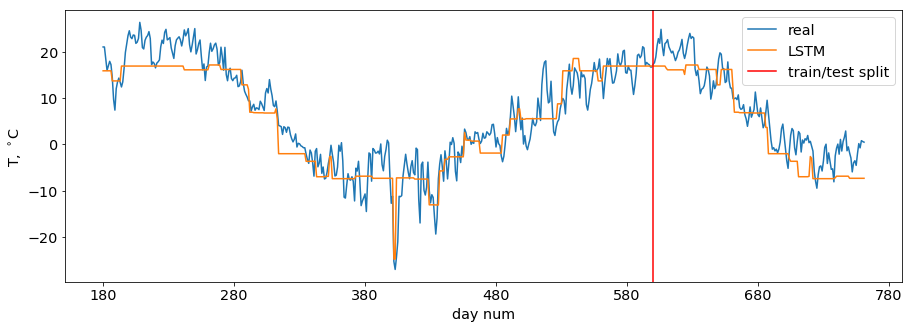

In [26]:
# plt.figure(figsize=(16,8))
plt.plot(testY, label='real')
plt.plot(pred, label='LSTM')
plt.axvline(x=(600 - look_back), color='red', label='train/test split')
plt.legend(loc='best')
locs, labels = plt.xticks()
plt.xlabel('day num')
plt.ylabel('T, $^\circ$C')
labels = range(80, 800, 100)
ax = plt.axes().set_xticklabels(labels)
plt.show()

In [27]:
MSE(pred[-162:], testY[-162:])

20.607790742180647

In [28]:
torch.save(model.state_dict(), 'model')